### VAR model for macro fundamentals forecasts

 1) https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
 
 2)https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618#:~:text=VAR%20model%20involves%20multiple%20independent,has%20more%20than%20one%20equations.&text=If%20the%20answer%20is%20%E2%80%9Cyes,of%20a%20VAR%20in%20levels.

Vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. 

The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

**VAR(1)** model for **k=2** takes the following form:

$
y_{1,t}=c_{1}+a_{1,1}y_{{1,t-1}}+a_{1,2}y_{{2,t-1}}+e_{1,t}
$

The above form can be recasted into a matrix form

$
{\begin{bmatrix}y_{{t}}\\y_{{t-1}}\end{bmatrix}}={\begin{bmatrix}c_{1}\\c_{2}\end{bmatrix}}+{\begin{bmatrix}a_{{1,1}}&a_{{1,2}}\\a_{{2,1}}&a_{{2,2}}\end{bmatrix}}{\begin{bmatrix}y_{{t-1}}\\y_{{t-2}}\end{bmatrix}}+{\begin{bmatrix}e_{{1,t}}\\e_{{2,t}}\end{bmatrix}}
$

In [5]:
%matplotlib inline

import os
import sys
import warnings
from datetime import date
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Dataset and Helper Functions 

In [122]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Unit Root Test

In [116]:
def unit_root_test(df):
    x= f'{pd.Series(adfuller(df)).iloc[1]:.2}'
    return print('p-value:',x)

**Data set :** Industry Production , Consumer Setiment

**Source:** Fred, Monthly series

**Time :** 1970-2017

In [117]:
sentiment = 'UMCSENT'
data = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2017-12').dropna()

In [118]:
data.columns= ["Sentiment","Industry_Production"]
data

,Sentiment,Industry_Production
DATE,,
1972-02-01,92.8,36.5706
1972-05-01,88.6,38.0932
1972-08-01,95.2,37.8353
1972-11-01,90.7,40.1290
1973-02-01,81.9,40.8257
...,...,...
2017-08-01,96.8,104.1295
2017-09-01,95.1,103.7343
2017-10-01,100.7,105.5815


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 1972-02-01 to 2017-12-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sentiment            504 non-null    float64
 1   Industry_Production  504 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f83940850>,
      dtype=object)

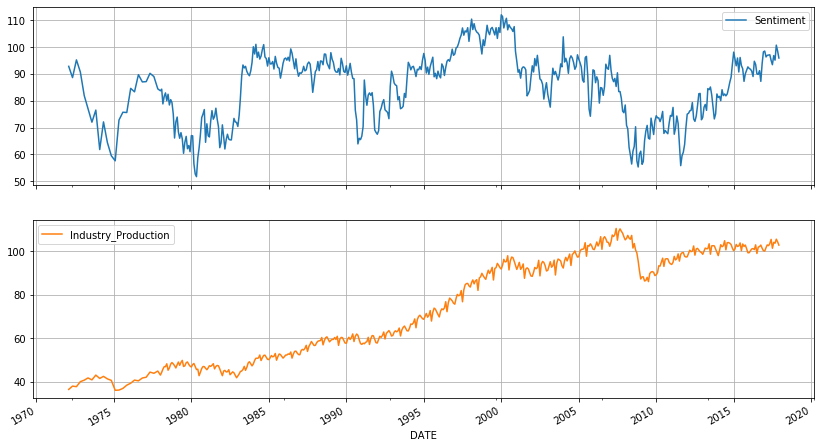

In [123]:
data.plot(subplots=True, figsize=(14,8),grid=True)

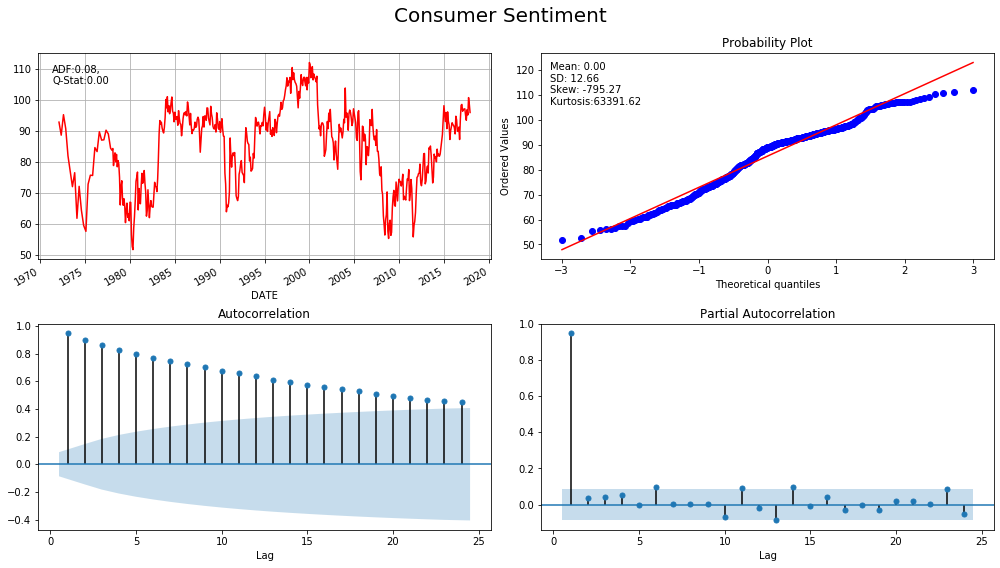

In [124]:
correlogram(data.Sentiment,24,'Consumer Sentiment')


In [ ]:
correlogram(data.Industry_Production,24,'Industry Production')

###  DataTransformation

In [15]:
transform_data = pd.DataFrame({'Industrial_production':np.log(data.Industry_Production).diff(12),'Sentiment':np.log(data.Sentiment).diff(12)}).dropna()

In [17]:
transform_data.shape

(492, 2)

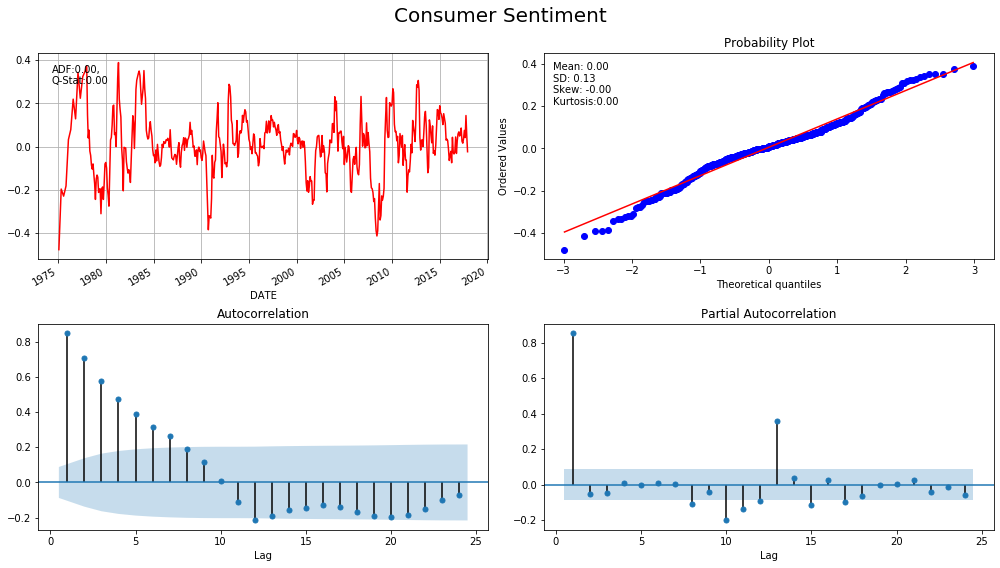

In [19]:
correlogram(transform_data.Sentiment,24,'Consumer Sentiment')

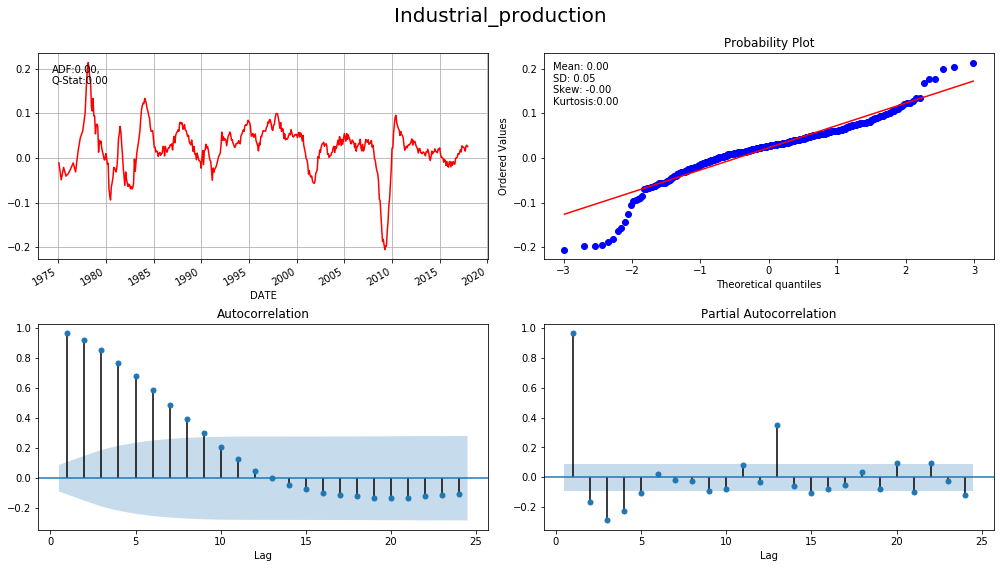

In [20]:
correlogram(transform_data.Industrial_production,24,'Industrial_production')

In [90]:
unit_root_test(transform_data.Industrial_production)

p-value: 0.00026


In [91]:
unit_root_test(transform_data.Sentiment)

p-value: 1e-05


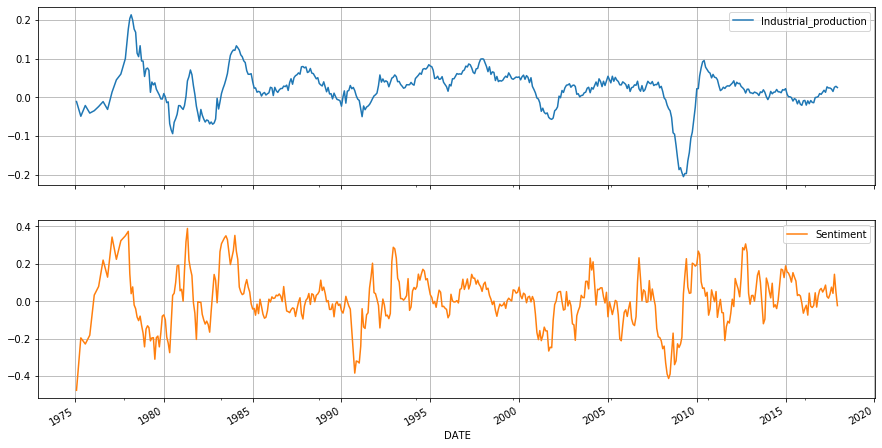

In [85]:
transform_data.plot(subplots=True, figsize=(15,8),grid=True);

### VARMAX(1) model  and Residual Diagnostics

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html

In [92]:
transform_data.shape

(492, 2)

In [101]:
var_model = VARMAX(transform_data.iloc[:450], order=(1,1), trend='c').fit(maxiter=1000)
print(var_model.summary())

                                     Statespace Model Results                                     
Dep. Variable:     ['Industrial_production', 'Sentiment']   No. Observations:                  450
Model:                                         VARMA(1,1)   Log Likelihood                1888.616
                                              + intercept   AIC                          -3751.233
Date:                                    Mon, 29 Jun 2020   BIC                          -3697.813
Time:                                            19:46:39   HQIC                         -3730.178
Sample:                                                 0                                         
                                                    - 450                                         
Covariance Type:                                      opg                                         
Ljung-Box (Q):              120.74, 156.68   Jarque-Bera (JB):        103.10, 31.89
Prob(Q):                 

Text(0.5, 0.98, 'Residuals for Industry Production')

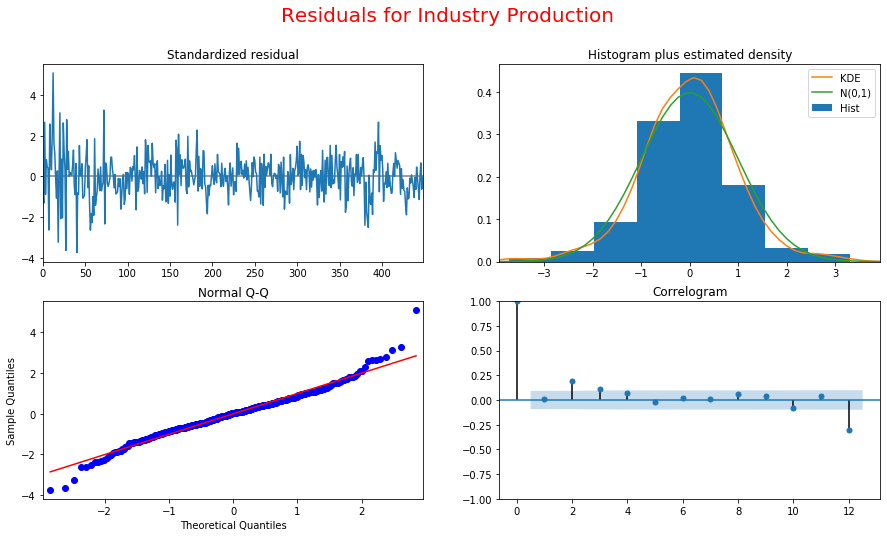

In [112]:
var_model.plot_diagnostics(variable=0,lags=12,figsize=(15,8))
plt.gcf().suptitle('Residuals for Industry Production',color='Red',fontsize=20)

Text(0.5, 0.98, 'Residuals for consumer sentiment')

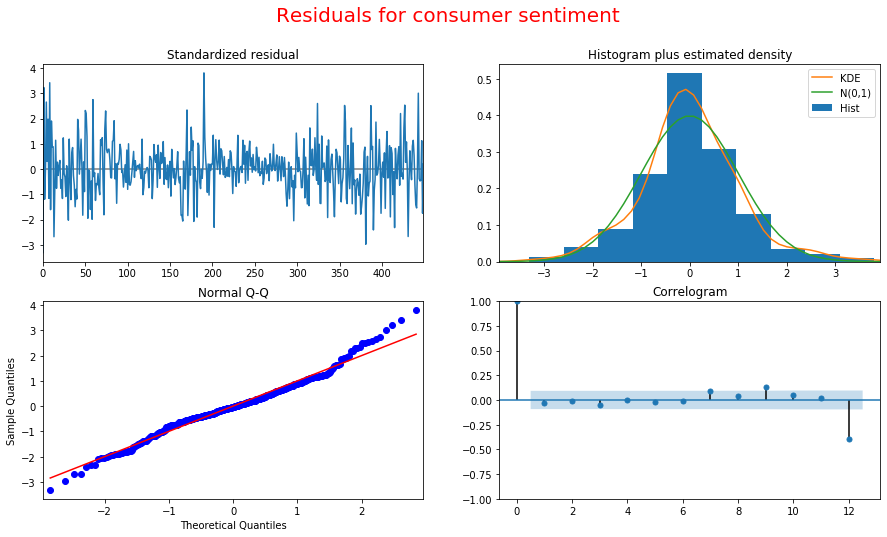

In [114]:
var_model.plot_diagnostics(variable=1,lags=12,figsize=(15,8))
plt.gcf().suptitle('Residuals for consumer sentiment',color='Red',fontsize=20)

### Impulse Response Analysis of VAR Models

http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/xaghtmlnode109.html#:~:text=1%20Impulse%20Response%20Analysis,exogenous%20shock%20to%20the%20model.&text=The%20reaction%20is%20measured%20for,time%20after%20shocking%20the%20system.


1.The IRA quantifies the reaction of every single variable in the model on an exogenous shock to the model

2.IRA helps us to trace the transmission of a single shock within an otherwise noisy system of equations and useful in assessment of economic policies

3.Cases of shocks

a) **Single equation shock** : we investigate forecast error impulse responses
 
b) **Joint equation shock**: shock mirrors the residual covariance structure, we investigate orthogonalized impulse 
  responses.
  
  
### *Forecast error impulse response*

Variables in a VAR model is a function of each other and individual coefficient estimates only provide limited information on the reaction of the system to a shock. Hence, Impulse responses are used to understand the dynamic behaviout of the model 

In order to get a better picture of the model’s dynamic behaviour, impulse responses (IR) are used. 

The departure point of every IRF for a linear VAR model is  moving average (MA) representation

It is also called as forecast error impulse response (FEIR) function. 

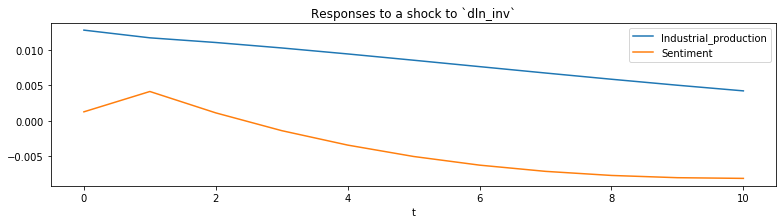

In [126]:
ax = var_model.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `dln_inv`');

In [138]:
irf=var_model.irf(12)

In [135]:
var_model = VAR(transform_data.iloc[:450]).fit()

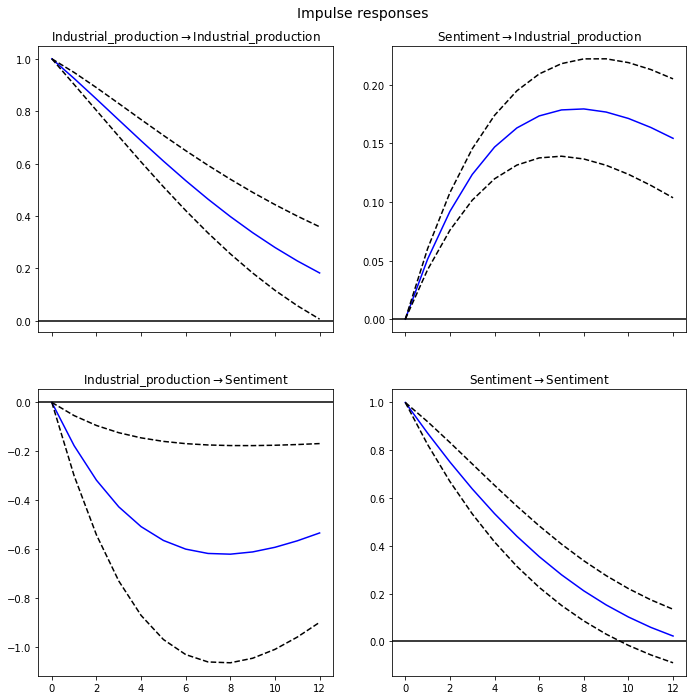

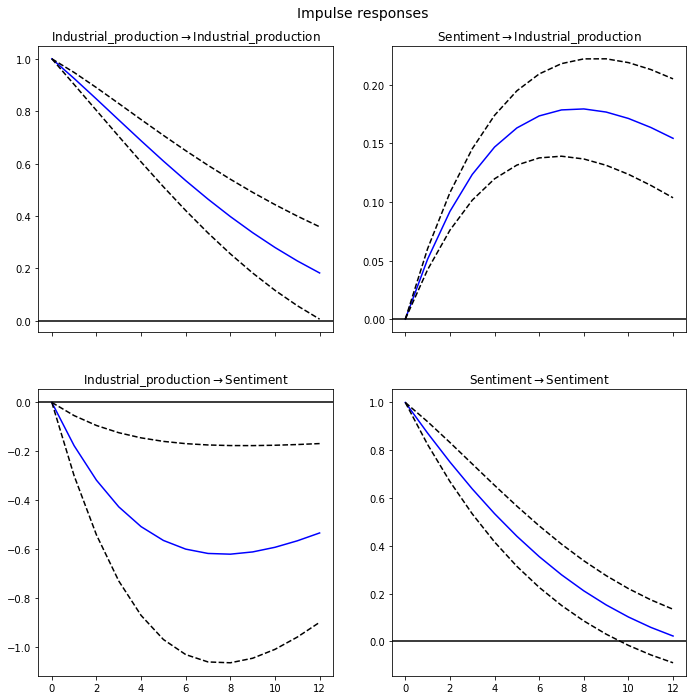

In [139]:
irf.plot(orth=False)

In [140]:
var_model.plot_diagnostics(variable=0,lags=12,figsize=(15,8))
plt.gcf().suptitle('Residuals for Industry Production',color='Red',fontsize=20)

AttributeError: 'VARResults' object has no attribute 'plot_diagnostics'

#### Impulse response for VARMAX

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html
    
 
write the equation 

https://www.r-econometrics.com/timeseries/irf/
    

    chrisbrooks page :298
        
        
        


In [141]:
mdata = sm.datasets.macrodata.load_pandas().data

most important link : https://www.statsmodels.org/dev/vector_ar.html#impulse-response-analysis